Preamble and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NOTE: This notebook assignment is currently under construction, and will likely change over time

# Linear regression and learning operators

You've likely encountered linear regression before in the context of fitting lines to data; it represents an interpretable "null hypothesis" model for finding trends in data. However, here we want to think a little more about how to interpret and understand linear regression, and so we will study a different context: learning Markov dynamical models from observations

+ What does ridge penalty do to the system?
+ Nonlinear systems: Picking the right features, and having an invertible feature transform


Two tasks: prediction of RE and regression


## The Navier-Stokes equations

The full Navier-Stokes equations comprise a hyperbolic set of partial differential equations,
$$
\rho\left(\dfrac{\partial \mathbf{u}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u}       \right) = -\nabla p + \mu \nabla \cdot \left(    (\nabla \mathbf{u} + (\nabla \mathbf{u})^T) - \dfrac{2}{3} (\nabla \cdot \mathbf{u})\mathbf{I}          \right) + \mathbf{F}
$$
This equation describes several interacting phenomena. The first parenthetical term proportional to the local density $\rho$ corresponds to inertial forces, while the second term corresponds to pressure gradients in the fluid. The term proportional to the viscousity, $\rho$, represents the effect of viscous drag within the fluid, while the forcing term $\mathbf F$ corresponds to external forces.

We usually supplement this partial differential equation with an additional equation describing conservation of momentum,
$$
\dfrac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{v}) = 0.
$$

Note that the full Navier-Stokes equations describe the dynamical evolution of three coupled fields: the velocity field $\mathbf{u}$, the local density $\rho$, and the pressure $p$. Usually, we will not attempt to directly solve the full equations, but instead we will first reduce these equations to a more specific form based on constraints or symmetries relevant to a specific problem

## The vortex street revisited

We've already seen the von Karman vortex street in a previous homework assignment. 

## To Do

+ Implement a Ridge Regression model yourself and predict the next values of the Navier-Stokes equations. I've included an object below that will handle creating train/val/test splits for you, and I've also included placeholder code to get you started on the regression model. For now, just implement the "global" solution method to the ridge regression problem. You can implement an iterative solution if you want to try something harder.
+ You'll notice that my train/test split in the ForecastingDataset object ensures that the test data occurs after the training data in the time series, and that no data points are repeated. Why do you think this is important for this problem?
+ Our model has a single hyperparameter, the regularizer strength, that determines the degree to which the weight entries in the regression matrix are penalized. Using the validation fold of our training dataset, find the best value of that hyperparameter.
+ We are treating our forecasting problem like a black box regression problem---we seek to find a linear map between two vectors, which happen to be flattened snapshots of the velocity field. However, since we know that our problem is a fluid flow, we can exploit our domain knowledge to improve how our model sees the data---in the language of ML, we can improve our model with an "inductive bias." From the numerical integration homework, we know that solving spatial PDEs involves calculating discrete Laplace operators, or taking the spatial Fourier transform. Using my code outlined below, implement a function that featurizes each snapshot of a velocity field array by adding spatial gradients and frequencies as features. Re-run your forecasting with this improved featurization of the data.
+ Repeat your experiments using datasets with different Reynolds numbers. How does forecast accuracy generally change with Reynolds number?
+ There are plenty of other ways to solve a regression problem. In the last code cells below, we use implementations of several regression models included in the Python package scikit-learn. Check out how these models perform. Are there any surprises? Look up some background info on some of the models that seem to perform particularly well. Why do you think they seem to work so well on this problem?

## Advanced problems (optional, if interested)

+ You'll notice that we downsampled our velocity field data. That's because the matrix operations needed to convert the weight matrix become burdensome when the dataset is sufficiently large. Instead of directly solving our objective function with matrix algebra, we can instead iteratively solve it using gradient descent. Try implementing a gradient descent solution to the linear regression problem. For my version of the solution, I added a private method to the LinearRegressor object, and a keyword argument to the constructor that chooses between global and iterative solving. 
+ A more advanced problem: Instead of the ridge penalty, we can use the Lasso, or L1, regularization term: $$\mathcal{L}(\theta) = \sum_{i} |\theta_i|$$. This is a little bit trickier to implement than ridge regression, because the loss is not differentiable at $0$.

## Additional information

+ There are lots of summaries of the Navier-Stokes equations, their reductions, and the kinds of approximations that people use to numerically solve them. I find the description of the [NS equations in the COMSOL documentation](https://www.comsol.com/multiphysics/navier-stokes-equations) to have some of the most consistent notation and concise exposition that I've found---which is remarkable, given that these are docs for a software package.
+ Applications of deep learning to flow field modelling and prediction is an active area of research. One of my favorite papers in this area highlights [physics-informed neural networks](https://www.science.org/doi/abs/10.1126/science.aaw4741), where the same differentiability that faciliates gradient descent also allows calculation of gradient terms in the governing equations for the fluid flow.

Velocity field data has shape: (300, 64, 32, 2)


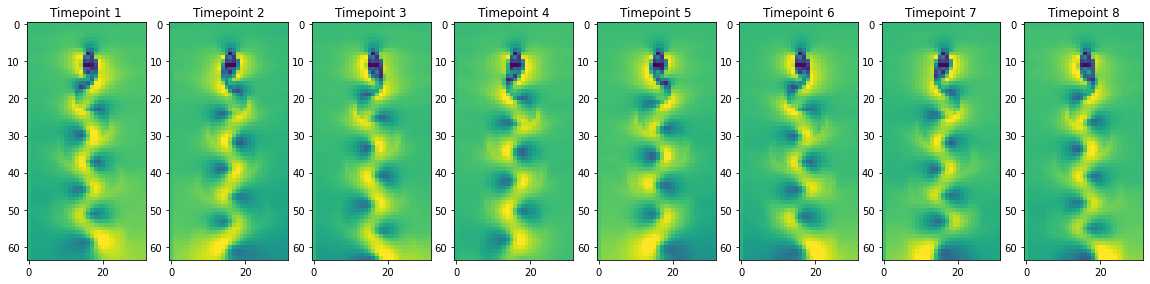

In [3]:

## Load the velocity field data

Re = 300 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"../resources/von_karman_street/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
# downsample the data for faster training
vfield = vfield[::10, ::4, ::4]
print("Velocity field data has shape: {}".format(vfield.shape))

# Compute the velocity magnitude
vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

n_tpts = vfield.shape[0]
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    v_vals = vfield_mag[n_tpts // 8 * i]
    plt.imshow(v_vals, cmap="viridis", vmin=0, vmax=np.percentile(v_vals, 99))
    plt.title("Timepoint {}".format(i + 1))

In [4]:
class ForecastingDataset:
    """
    A class for formatting time series data for forecasting.
    By convention, time is assumed to be the first dimension of the dataset.

    For time series data, it is very important that all data in test set is after 
    all data in the train and val sets. We also need to ensure that datapoints don't
    appear in multiple splits. 

    Parameters
        X (np.ndarray): The time series data. The first dimension is assumed to be time.
        split_ratio (tuple): The ratio of the data to be used for train, val, and test.
        forecast_horizon (int): The number of time steps to forecast at once
        featurizer (callable): A function that takes in multivariate snapshot and 
            returns a feature vector. If None, the raw data is used.
    """

    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2), forecast_horizon=1, featurizer=None):

        if featurizer is None:
            self.featurizer = lambda x: x
        else:
            self.featurizer = featurizer

        self.feature_shape = X.shape[1:]

        # We need to ensure that datapoints don't appear in multiple splits, hence why
        # we crop by the forecast horizon. We are going to do one-step forecasting
        self.X_full = self.featurizer(X[:-1])#[:-forecast_horizon]
        self.y_full = X[1:]#[forecast_horizon:]
        self.forecast_horizon = forecast_horizon

        # Split the data into train, val, test
        n_train = int(len(self.X_full) * split_ratio[0])
        n_val = int(len(self.X_full) * split_ratio[1])
        n_test = len(self.X_full) - n_train - n_val

        # Our frequent use of the forecast_horizon parameter again arises from our need
        # to ensure that datapoints don't appear in multiple splits.
        self.X_train, self.y_train = self.X_full[:n_train], self.y_full[:n_train]
        self.X_val, self.y_val = (
            self.X_full[n_train + forecast_horizon : n_train + forecast_horizon + n_val], 
            self.y_full[n_train+ forecast_horizon:n_train + forecast_horizon + n_val]
        )
        self.X_test, self.y_test = (
            self.X_full[n_train + 2 * forecast_horizon+ n_val:], 
            self.y_full[n_train + 2 * forecast_horizon + n_val:]
        )

    def __len__(self):
        return len(self.X_full)

    def __getitem__(self, idx):
        return self.X_full[idx], self.y_full[idx]

    def flatten_data(self, x):
        """
        Given a dataset, transform into a flat feature form
        """
        return np.reshape(x, (x.shape[0], -1))

    def unflatten_data(self, x):
        """
        Given a flat dataset, convert back to the original shape
        """
        out = np.reshape(x, (x.shape[0], *self.feature_shape))
        return out



# Let's do a simple unit test to make sure that our class is working as expected
# Take some time to understand what these test cases cover
import unittest
class TestForecastingDataset(unittest.TestCase):
    def test_initialization(self):
        fd = ForecastingDataset(np.arange(100)[:, None])
        assert fd.y_train[0] == fd.X_train[1], "y_train is not shifted by 1 from X_train"
        assert fd.y_val[0] == fd.X_val[1], "y_val is not shifted by 1 from X_val"
        assert fd.y_test[0] == fd.X_test[1], "y_test is not shifted by 1 from X_test"
        
        assert fd.y_train[-1] < fd.y_val[0], "y_train and y_test are not disjoint"
        assert fd.y_val[-1] < fd.y_test[0], "y_val and y_test are not disjoint"

unittest.main(argv=[''], exit=False);



.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


# Implement the Ridge regression model

In [5]:
import numpy as np
import warnings
import matplotlib.pyplot as plt


class BaseRegressor:
    """
    A base class for regression models.
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the data.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def predict(self, X):
        return X @ self.weights + self.bias

    def score(self, X, y):
        """
        Returns the mean squared error of the model.
        """
        return np.mean((self.predict(X) - y)**2)




class LinearRegressor(BaseRegressor):
    """
    A linear regression model is a linear function of the form:
    y = w0 + w1 * x1 + w2 * x2 + ... + wn * xn

    The weights are the coefficients of the linear function.
    The bias is the constant term w0 of the linear function.

    Attributes:
        method: str, optional. The method to use for fitting the model.
        regularization: str, optional. The type of regularization to use.
    """
    
    def __init__(self, method="global", regularization="ridge", regstrength=0.1, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    # functions that begin with underscores are private, by convention.
    # Technically we could access them from outside the class, but we should
    # not do that because they can be changed or removed at any time.
    def _fit_global(self, X, y):
        """
        Fits the model using the global least squares method.
        """
        if self.regularization is None:
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        elif self.regularization == "ridge":
            self.weights = np.linalg.inv(X.T @ X + np.eye(X.shape[1]) * self.regstrength) @ X.T @ y
        else:
            warnings.warn("Unknown regularization method, defaulting to None")
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        self.bias = np.mean(y - X @ self.weights)
        return self.weights, self.bias

    def _fit_iterative(self, X, y, learning_rate=0.01):
        """
        Fit the model using gradient descent.
        """
        self.weights = np.zeros((X.shape[1], X.shape[1]))
        self.bias = np.mean(y)
        for i in range(X.shape[0]):
            self.weights += learning_rate * (y[i] - X[i] @ self.weights - self.bias) * X[i] - self.regstrength * self.weights
        self.weights /= X.shape[0]
        return self.weights, self.bias

    def fit(self, X, y):
        """
        Fits the model to the data. The method used is determined by the
        `method` attribute.
        """
        if self.method == "global":
            out = self._fit_global(X, y)
        elif self.method == "iterative":
            out = self._fit_iterative(X, y)
        else:
            out = self._fit_global(X, y)
        return out


In [7]:
# Automatically split the data into train, validation, and test sets
dataset= ForecastingDataset(vfield_mag)

Text(0.5, 0, 'Time step')

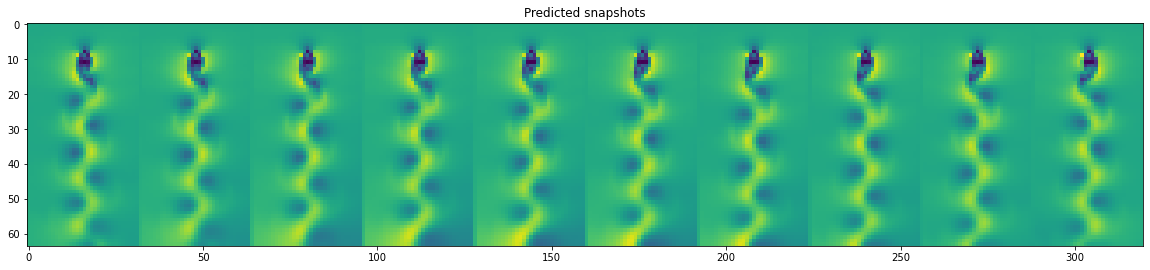

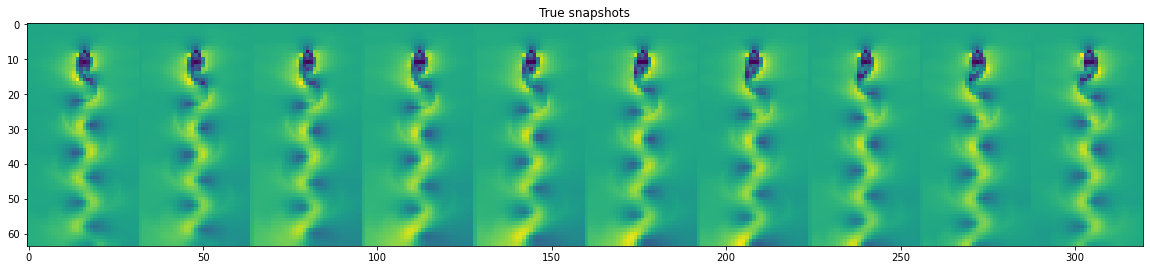

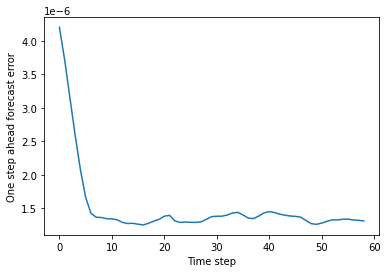

In [8]:
# Import William's solution
# from solutions.linear_regression import LinearRegressor

model = LinearRegressor(method="global", regularization="ridge", regstrength=0.1)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")


# Run hyperparameter tuning

In [9]:
regstrengths = np.logspace(-4, 4, 9)

all_mse = []
for regstrength in regstrengths:
    print(f"Training model with regstrength={regstrength}", flush=True)

    model = LinearRegressor(method="global", regularization="ridge", regstrength=regstrength)

    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )

    y_test_pred = dataset.unflatten_data(
        model.predict(dataset.flatten_data(dataset.X_val))
    )

    mse = np.mean((y_test_pred - dataset.y_val)**2, axis=(1, 2))
    all_mse.append(mse)

best_regstrength = regstrengths[np.argmin(np.array(all_mse))]

print(f"Best regularize strength: {best_regstrength}")


Training model with regstrength=0.0001
Training model with regstrength=0.001
Training model with regstrength=0.01
Training model with regstrength=0.1
Training model with regstrength=1.0
Training model with regstrength=10.0
Training model with regstrength=100.0
Training model with regstrength=1000.0
Training model with regstrength=10000.0
Best regularize strength: 0.0001


Text(0.5, 0, 'Time step')

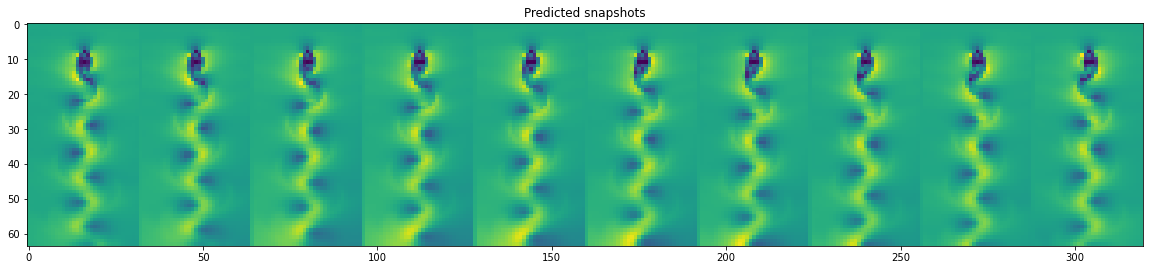

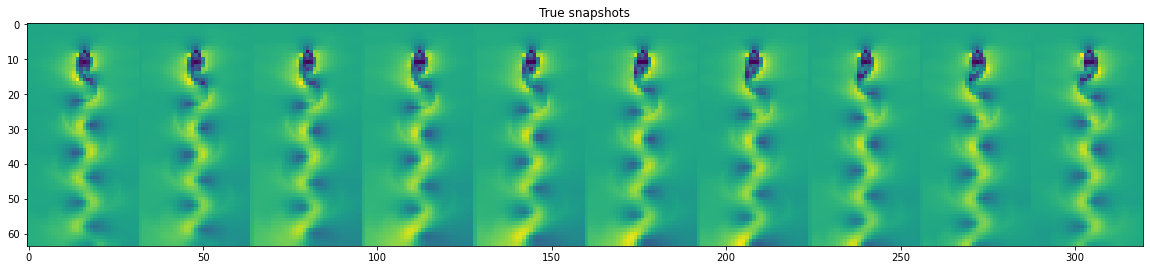

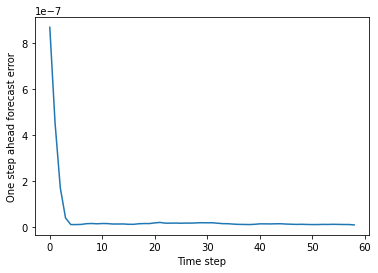

In [10]:
model = LinearRegressor(method="global", regularization="ridge", regstrength=best_regstrength)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")

mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")

# Improve the featurization of the velocity field dataset

In [19]:
def featurize_flowfield(field):
    """
    Compute features of a 2D spatial field. These features are chosen based on the 
    intuition that the flow field is a 2D spatial field with time translation 
    invariance.

    The output is an augmented feature vector including the original field, fourier 
    features, and the first and second order derivatives of the field.

    This implementation is vectorized along the first (batch) axis
    """
    ## Compute the Fourier features
    field_fft = np.fft.fft2(field)
    field_fft = np.fft.fftshift(field_fft)
    field_fft_abs = np.log(np.abs(field_fft) + 1e-8)[..., None]
    field_fft_phase = np.angle(field_fft)[..., None]

    # field_fft_real, field_fft_imag = (
    #     np.log(np.real(field_fft)[..., None] + 1e-8), 
    #     np.log(np.imag(field_fft)[..., None] + 1e-8)
    # )

    ## Compute the spatial gradients along x and y
    field_grad = np.gradient(field, axis=(-2, -1))
    field_grad = np.stack(field_grad, axis=-1)

    ## Compute the spatial Laplacian
    field_lap = np.stack(np.gradient(field_grad, axis=(-2, -1)), axis=-1)
    field_lap = np.sum(field_lap, axis=-1)

    field = field[..., None]

    ## Concatenate the features and original field
    # field_features = np.concatenate(
    #     [field, field_grad, field_lap, field_fft_abs], 
    #     axis=-1
    # )
    field_features = np.concatenate(
        [field, field_grad, field_lap, field_fft_phase, field_fft_abs], 
        axis=-1
    )
    return field_features

In [20]:
## Pass the data through the featurizer using the keyword argument
dataset_featurized = ForecastingDataset(vfield_mag, featurizer=featurize_flowfield)

Text(0.5, 0, 'Time step')

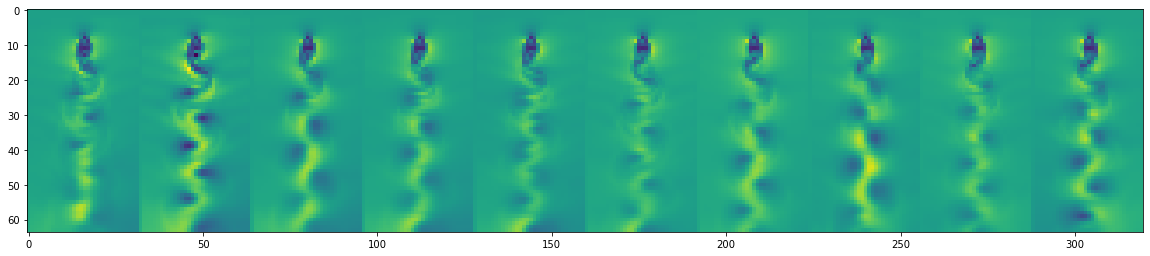

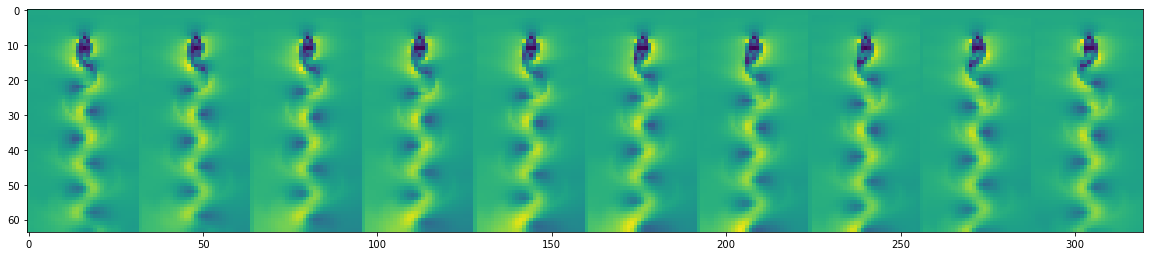

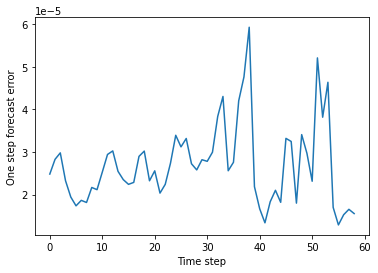

In [23]:
model = LinearRegressor(method="global", regularization="ridge", regstrength=1e-2)

model.fit(
    dataset_featurized.flatten_data(dataset_featurized.X_train), 
    dataset_featurized.flatten_data(dataset_featurized.y_train)
)

y_test_pred = dataset_featurized.unflatten_data(
    model.predict(
        dataset_featurized.flatten_data(dataset_featurized.X_test)
    )
)

plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(y_test_pred[::3][-10:])
)
plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(dataset.y_test[::3][-10:])
)


plt.figure()
plt.plot(np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2)))
plt.ylabel("One step forecast error")
plt.xlabel("Time step")



# Try some other regression models

Make sure you've installed scikit-learn in your local environment

    conda install scikit-learn


Text(0.5, 0, 'Time step')

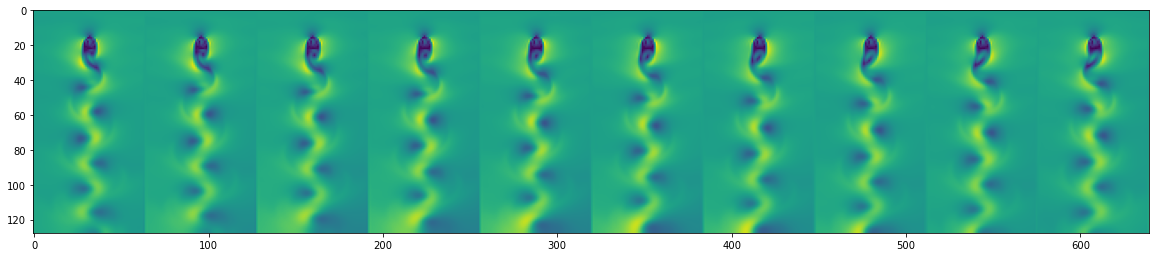

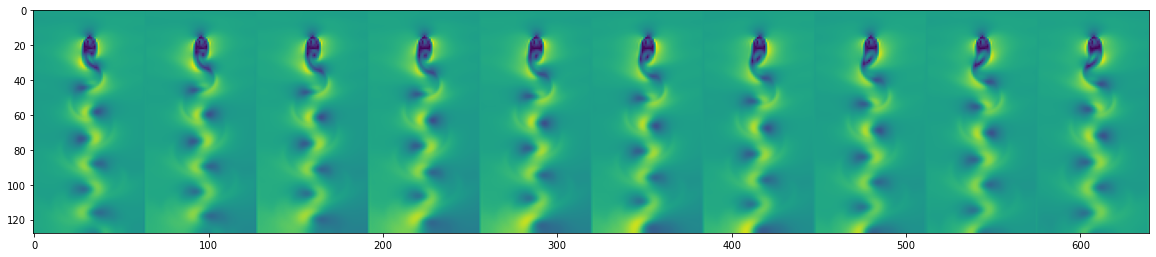

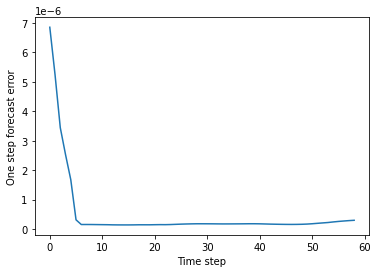

In [98]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB


# model = MLPRegressor(alpha=1.0, hidden_layer_sizes=200)
# model = GaussianProcessRegressor()
model = KNeighborsRegressor()
model.fit(dataset.flatten_data(dataset.X_train), dataset.flatten_data(dataset.y_train))

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(
        dataset.unflatten_data(
            model.predict(dataset.flatten_data(dataset.X_test))
        )[::3][-10:]
    )
)

plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(dataset.y_test[::3][-10:])
)


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step forecast error")
plt.xlabel("Time step")

Text(0.5, 0, 'Time step')

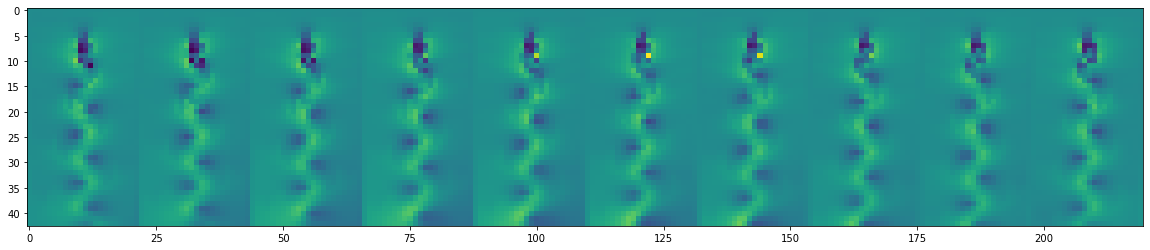

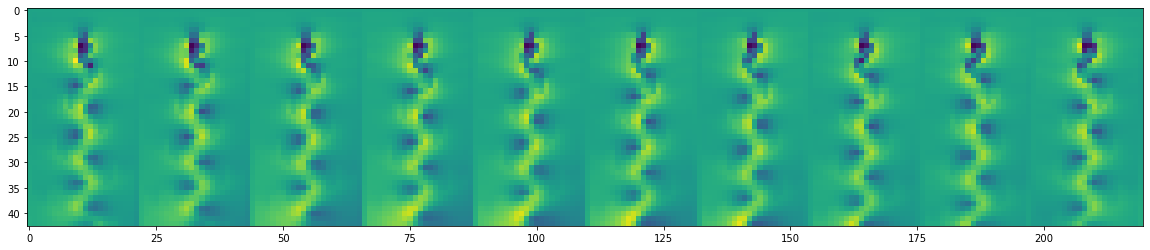

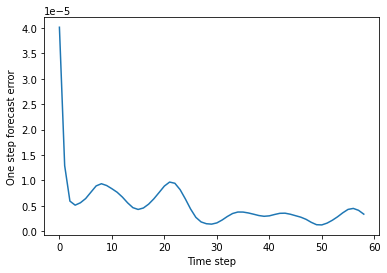

In [43]:
dataset.flatten_data(dataset.X_train).shape


from sklearn.linear_model import LinearRegression, Ridge

sklearn_model = LinearRegression()
sklearn_model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    sklearn_model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(
        dataset.unflatten_data(
            sklearn_model.predict(dataset.flatten_data(dataset.X_test))
        )[::3][-10:]
    )
)

plt.figure(figsize=(20, 10))
plt.imshow(
    np.hstack(dataset.y_test[::3][-10:])
)


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step forecast error")
plt.xlabel("Time step")


In [ ]:
class FiniteTimeLyapunovExponent:

    def __init__(self, X, y, method="global", regularization=None, regstrength=0.0, **kwargs):
        self.X = X
        self.y = y
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    def fit(self):
        self.model = LinearRegressor(method=self.method, regularization=self.regularization, regstrength=self.regstrength)
        self.model.fit(self.X, self.y)
        self.weights = self.model.weights
        self.bias = self.model.bias
        return self.weights, self.bias

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def get_finite_time_lyapunov_exponent(self):
        return np.log(np.abs(self.weights)) / self.X.shape[0]